# Polars w/ NVIDIA RAPIDS

* <b>pl.DataFrame</b> v <b>pl.LazyFrame</b> - complex, pipeline queries
* <b>pl.scan_csv()</b> v <b>pl.read_csv()</b>
* visual query optimization w/ <b>.describe_optimized_plan()</b>
* demonstrate <b>.collect()</b> w/ and w/out <b>GPU</b>

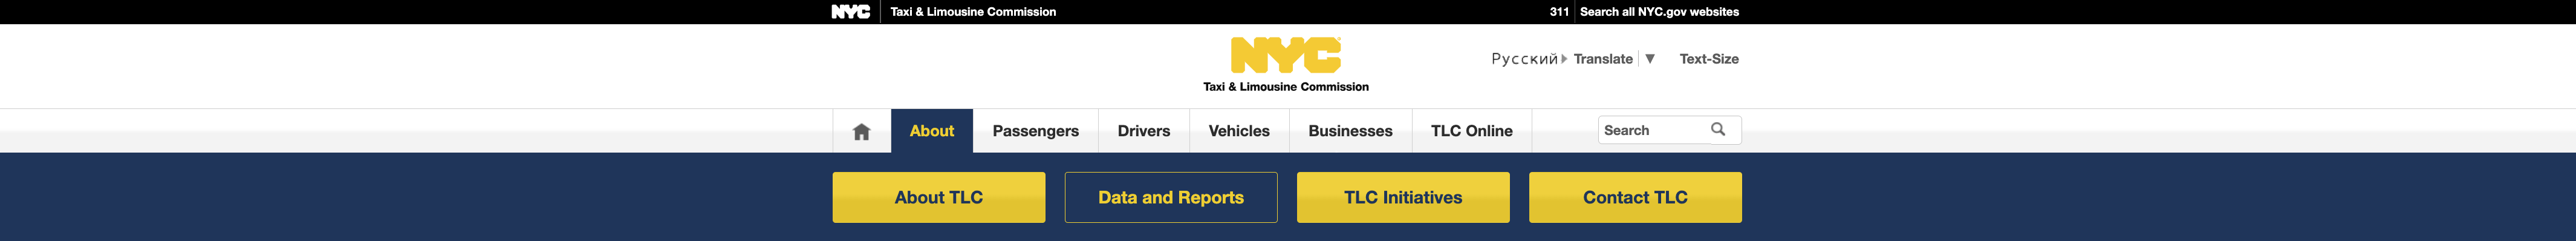

# NYC Taxi Data
##### https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page
### Data Dictionary
##### https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_hvfhs.pdf

### Install Polars with NVIDIA RAPIDS
##### pip -q install --upgrade polars[gpu]
##### pip freeze | grep polars

In [1]:
%load_ext cudf.pandas
import pandas as pd


import polars as pl
import os

In [2]:
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet

--2025-02-21 13:55:33--  https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet
3.167.84.127, 3.167.84.228, 3.167.84.131, ...i6vzurychx.cloudfront.net)... 
connected. to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|3.167.84.127|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 1362284 (1.3M) [binary/octet-stream]
Saving to: ‘green_tripdata_2024-01.parquet’

green_tripdata_2024 100%[===================>]   1.30M  --.-KB/s    in 0.07s   

2025-02-21 13:55:34 (19.4 MB/s) - ‘green_tripdata_2024-01.parquet’ saved [1362284/1362284]



In [3]:
import pyarrow.parquet as pq
# 2024-01 - request_datetime: timestamp[us]
# 2024-11 - request_datetime: timestamp[us]
pq.read_table('green_tripdata_2024-01.parquet')

pyarrow.Table
VendorID: int32
lpep_pickup_datetime: timestamp[us]
lpep_dropoff_datetime: timestamp[us]
store_and_fwd_flag: large_string
RatecodeID: int64
PULocationID: int32
DOLocationID: int32
passenger_count: int64
trip_distance: double
fare_amount: double
extra: double
mta_tax: double
tip_amount: double
tolls_amount: double
ehail_fee: double
improvement_surcharge: double
total_amount: double
payment_type: int64
trip_type: int64
congestion_surcharge: double
----
VendorID: [[2,2,2,1,2,...,2,2,2,2,2]]
lpep_pickup_datetime: [[2024-01-01 00:46:55.000000,2024-01-01 00:31:42.000000,2024-01-01 00:30:21.000000,2024-01-01 00:30:20.000000,2024-01-01 00:32:38.000000,...,2024-01-31 20:46:00.000000,2024-01-31 21:06:00.000000,2024-01-31 21:36:00.000000,2024-01-31 22:45:00.000000,2024-01-31 22:28:00.000000]]
lpep_dropoff_datetime: [[2024-01-01 00:58:25.000000,2024-01-01 00:52:34.000000,2024-01-01 00:49:23.000000,2024-01-01 00:42:12.000000,2024-01-01 00:43:37.000000,...,2024-01-31 20:55:00.000000,20

In [4]:
pl.scan_parquet('green_tripdata_2024-01.parquet').collect(engine="gpu")

ComputeError: AssertionError: 

In [6]:
lf_11 = pl.scan_parquet('nyc_taxi_parquet/fhvhv_tripdata_2024-11.parquet')
lf_01 = pl.scan_parquet('nyc_taxi_parquet/fhvhv_tripdata_2024-01.parquet')

lf_11 = lf_11.filter((pl.col("request_datetime").dt.year() == 2024) &
                     (pl.col("request_datetime").dt.month() == 11))

lf_11.collect(engine="gpu")

FileNotFoundError: No such file or directory (os error 2): nyc_taxi_parquet/fhvhv_tripdata_2024-11.parquet

This error occurred with the following context stack:
	[1] 'parquet scan'
	[2] 'filter'


In [6]:
pd.read_parquet('nyc_taxi_parquet/fhvhv_tripdata_2024-01.parquet').head(3)

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B03404,B03404,2024-01-01 00:21:47,2024-01-01 00:25:06,2024-01-01 00:28:08,2024-01-01 01:05:39,161,158,2.83,...,4.05,2.75,0.0,0.0,40.18,N,N,N,N,N
1,HV0003,B03404,B03404,2024-01-01 00:10:56,2024-01-01 00:11:08,2024-01-01 00:12:53,2024-01-01 00:20:05,137,79,1.57,...,0.89,2.75,0.0,0.0,6.12,N,N,N,N,N
2,HV0003,B03404,B03404,2024-01-01 00:20:04,2024-01-01 00:21:51,2024-01-01 00:23:05,2024-01-01 00:35:16,79,186,1.98,...,1.60,2.75,0.0,0.0,9.47,N,N,N,N,N


In [7]:
pl.scan_parquet('nyc_taxi_parquet/fhvhv_tripdata_2024-01.parquet').collect().head(3)

hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
str,str,str,datetime[ns],datetime[ns],datetime[ns],datetime[ns],i32,i32,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str
"""HV0003""","""B03404""","""B03404""",2024-01-01 00:21:47,2024-01-01 00:25:06,2024-01-01 00:28:08,2024-01-01 01:05:39,161,158,2.83,2251,45.61,0.0,1.25,4.05,2.75,0.0,0.0,40.18,"""N""","""N""","""N""","""N""","""N"""
"""HV0003""","""B03404""","""B03404""",2024-01-01 00:10:56,2024-01-01 00:11:08,2024-01-01 00:12:53,2024-01-01 00:20:05,137,79,1.57,432,10.05,0.0,0.28,0.89,2.75,0.0,0.0,6.12,"""N""","""N""","""N""","""N""","""N"""
"""HV0003""","""B03404""","""B03404""",2024-01-01 00:20:04,2024-01-01 00:21:51,2024-01-01 00:23:05,2024-01-01 00:35:16,79,186,1.98,731,18.07,0.0,0.5,1.6,2.75,0.0,0.0,9.47,"""N""","""N""","""N""","""N""","""N"""


In [8]:
pl.scan_parquet('nyc_taxi_parquet/fhvhv_tripdata_2024-01.parquet').collect(engine="gpu").head(3)

ComputeError: AssertionError: 

In [4]:
lf_01 = pl.scan_parquet('nyc_taxi_parquet/fhvhv_tripdata_2024-01.parquet')
lf_01.collect(engine="gpu")

ComputeError: AssertionError: 

In [1]:
nyc_dir = 'nyc_taxi_parquet/'

pq_files = sorted([nyc_dir + filename for filename in os.listdir(nyc_dir) if filename.endswith(".parquet")], reverse=True)

In [2]:
lf_list = []

for pq_file in pq_files:
    lf_item  = pl.scan_parquet(pq_file) 
    lf_list.append(lf_item)


lf = lf_list[0]

In [3]:
MAX_FILES = 20

for idx, lf_item in enumerate(lf_list[1:]):
    lf = pl.concat([lf,lf_item], how="vertical_relaxed")
    if idx >= MAX_FILES:
        break

In [4]:
lf = lf.filter(
    (pl.col("request_datetime").dt.year() == 2024) 
    &
    (pl.col("request_datetime").dt.month() == 1)
)

lf.collect(engine="gpu")

ComputeError: AssertionError: 

In [ ]:
# Apply filtering (Now the column is already in the correct datetime format)
lf = lf.filter(
    (pl.col("request_datetime").dt.year() == 2024) &
    (pl.col("request_datetime").dt.month() == 1)
)

# Convert `request_datetime` from `datetime[μs]` to `datetime[ns]`
lf = lf.with_columns(pl.col("request_datetime").cast(pl.Datetime("ns")))

# Collect the results
df_result = lf.collect()

print(df_result.shape)

SchemaError: data type mismatch for column request_datetime: expected: datetime[ns], found: datetime[μs]

In [145]:
pl.scan_parquet?

Signature:
pl.scan_parquet(
    source: 'ScanSource',
    *,
    n_rows: 'int | None' = None,
    row_index_name: 'str | None' = None,
    row_index_offset: 'int' = 0,
    parallel: 'ParallelStrategy' = 'auto',
    use_statistics: 'bool' = True,
    hive_partitioning: 'bool | None' = None,
    glob: 'bool' = True,
    schema: 'SchemaDict | None' = None,
    hive_schema: 'SchemaDict | None' = None,
    try_parse_hive_dates: 'bool' = True,
    rechunk: 'bool' = False,
    low_memory: 'bool' = False,
    cache: 'bool' = True,
    storage_options: 'dict[str, Any] | None' = None,
    credential_provider: "CredentialProviderFunction | Literal['auto'] | None" = 'auto',
    retries: 'int' = 2,
    include_file_paths: 'str | None' = None,
    allow_missing_columns: 'bool' = False,
) -> 'LazyFrame'
Docstring:
Lazily read from a local or cloud-hosted parquet file (or files).

This function allows the query optimizer to push down predicates and projections to
the scan level, typically increasing p

In [144]:
import polars as pl

# Define schema override only for `request_datetime`
dtype = {"request_datetime": pl.Datetime("ns")}

# Scan multiple parquet files lazily with schema override
lf = pl.scan_parquet("nyc_taxi_parquet/*_2024-*.parquet", dtype=dtype)  # ✅ Use `dtype`, not `dtypes`

# Apply filtering (Now the column is already in the correct datetime format)
lf = lf.filter(
    (pl.col("request_datetime").dt.year() == 2024) &
    (pl.col("request_datetime").dt.month() == 1)
)

# Collect the results
df_result = lf.collect()

print(df_result.shape)

TypeError: scan_parquet() got an unexpected keyword argument 'dtype'

In [140]:
# Define the expected schema with datetime in ns precision
schema = {"request_datetime": pl.Datetime("ns")}

# Scan multiple parquet files lazily with schema enforcement
lf = pl.scan_parquet("nyc_taxi_parquet/*_2024-*.parquet", schema=schema)

# Apply filtering (Now the column is already in the correct datetime format)
lf = lf.filter(
    (pl.col("request_datetime").dt.year() == 2024) &
    (pl.col("request_datetime").dt.month() == 1)
)

# Collect the results
df_result = lf.collect()

print(df_result.shape)

SchemaError: parquet file contained extra columns and no selection was given

In [135]:
# Scan multiple parquet files lazily
lf = pl.scan_parquet("nyc_taxi_parquet/*_2024-*.parquet")

# Ensure datetime columns are in nanoseconds precision
datetime_cols = ["request_datetime"]
lf = lf.with_columns([pl.col(col).cast(pl.Datetime("ns"), strict=False) for col in datetime_cols])

# Apply filtering using parentheses
lf = lf.filter(
    (pl.col("request_datetime").dt.year() == 2024) &
    (pl.col("request_datetime").dt.month() == 1)
)

lf.collect()

SchemaError: data type mismatch for column request_datetime: expected: datetime[ns], found: datetime[μs]

In [132]:
lf = pl.scan_parquet("nyc_taxi_parquet/*_2024-*.parquet")

datetime_cols = ["request_datetime"]  

lf = lf.with_columns([pl.col(col).cast(pl.Datetime("ns")) for col in datetime_cols])

lf = lf.filter(
    (pl.col("request_datetime").dt.year() == 2024) & 
    (pl.col("request_datetime").dt.month() == 1)     
)

lf.collect()

SchemaError: data type mismatch for column request_datetime: expected: datetime[ns], found: datetime[μs]

In [20]:
month_int = 1
month_str = str(month_int).zfill(2)
pq_path = f"{nyc_taxi_dir}fhvhv_tripdata_2024-{month_str}.parquet"    
pq_path

'nyc-taxi-pq/fhvhv_tripdata_2024-01.parquet'

In [18]:
for month_int in range(1,4):
    month_str = str(month_int).zfill(2)
    print(month_str)
    pq_path = f"{nyc_taxi_dir}fhvhv_tripdata_2024-{month_str}.parquet"    
    print(pq_path)
    lf = pl.scan_parquet(pq_path)
    all_lazy_frames.append(lf)

# lf = pl.concat(all_months_lazy_frames, how="align")

01
nyc-taxi-pq/fhvhv_tripdata_2024-01.parquet
02
nyc-taxi-pq/fhvhv_tripdata_2024-02.parquet
03
nyc-taxi-pq/fhvhv_tripdata_2024-03.parquet


In [19]:
lf

ComputeError: parquet: File out of specification: The file must end with PAR1

In [ ]:
jan = "https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2024-01.parquet"
feb = "https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2024-02.parquet"
mar = "https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2024-03.parquet"

In [4]:
import polars as pl

In [5]:
# ~20M rows - Jan 25 : High Volume For-Hire Vehicle Trip Records
lf = pl.scan_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2024-01.parquet")

In [6]:
# Lazy query example: Count trips per year
result = (
    lf.with_columns(pl.col("pickup_datetime").cast(pl.Date))  # Convert to Date
      .group_by("pickup_datetime")
      .agg(pl.len().alias("num_trips"))
      .sort("pickup_datetime")
)

In [7]:
%%time
result.collect(engine="gpu")

CPU times: user 698 ms, sys: 495 ms, total: 1.19 s
Wall time: 905 ms


pickup_datetime,num_trips
date,u32
2024-01-01,638406
2024-01-02,478254
2024-01-03,498332
2024-01-04,572632
2024-01-05,656654
…,…
2024-01-27,752194
2024-01-28,702812
2024-01-29,550917


In [37]:
%%time
result.collect()

CPU times: user 721 ms, sys: 271 ms, total: 993 ms
Wall time: 623 ms


pickup_datetime,num_trips
date,u32
2024-01-01,638406
2024-01-02,478254
2024-01-03,498332
2024-01-04,572632
2024-01-05,656654
…,…
2024-01-27,752194
2024-01-28,702812
2024-01-29,550917


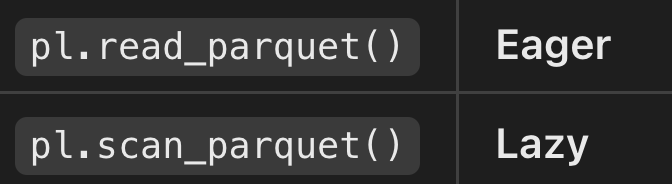

##### Select Specific Columns (Column Pruning)
✅ This only loads the specified columns, reducing memory usage.

In [ ]:

lf = pl.scan_parquet("nyc_taxi_data.parquet", columns=["tpep_pickup_datetime", "trip_distance"])


##### Filter Data Efficiently (Predicate Pushdown)
✅ Filters and selects columns before loading into memory, making it significantly faster.

In [ ]:
lf = pl.scan_parquet("nyc_taxi_data.parquet")

# Apply filter before collecting to optimize performance
df_filtered = (
    lf.filter(pl.col("trip_distance") > 2)
      .select(["tpep_pickup_datetime", "trip_distance"])
      .collect()
)

print(df_filtered)